# Multimodal Report Generation (from a Slide Deck)

<a href="https://colab.research.google.com/github/run-llama/llama_parse/blob/main/examples/multimodal/multimodal_report_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this cookbook we show you how to build a multimodal report generator. The pipeline parses a slide deck and stores both text and image chunks. It generates a detailed response that contains interleaving text and images.

**NOTE**: This pipeline operates over the entire document and does not do retrieval, in order to retrieve the full context. You can of course explore adding a higher-level retrieval layer where you retrieve the relevant document(s) first before feeding to a multimodal model.

## Setup

In [2]:
import nest_asyncio

nest_asyncio.apply()

In [20]:
import boto3
import os

import boto3
from botocore.exceptions import ClientError
import os

def download_file_from_s3(bucket_name: str, s3_key: str) -> str:
    s3 = boto3.client('s3')
    local_path = f"/tmp/{os.path.basename(s3_key)}"
    
    try:
        s3.download_file(bucket_name, s3_key, local_path)
        print("File downloaded successfully.")
    except ClientError as e:
        print(f"Error: {e}")
        if e.response['Error']['Code'] == "403":
            print("Access Denied: Check your permissions.")
        return None
    return local_path
# Example Usage
bucket_name = "cfapublications"
s3_key = "assignment3/pdfs/The Economics of Private Equity_ A Critical Review.pdf"

file_path = download_file_from_s3(bucket_name, s3_key)
print("File downloaded to:", file_path)

File downloaded successfully.
File downloaded to: /tmp/The Economics of Private Equity_ A Critical Review.pdf


### Setup Observability

We setup an integration with LlamaTrace (integration with Arize).

If you haven't already done so, make sure to create an account here: https://llamatrace.com/login. Then create an API key and put it in the `PHOENIX_API_KEY` variable below.

In [21]:
!poetry add llama-index-callbacks-arize-phoenix

Using version ^0.2.1 for llama-index-callbacks-arize-phoenix

Updating dependencies
Resolving dependencies... (0.0s)

The current project's supported Python range (>=3.12,<4.0) is not compatible with some of the required packages Python requirement:
  - llama-index-callbacks-arize-phoenix requires Python <3.13,>=3.8.1, so it will not be satisfied for Python >=3.13,<4.0

Because no versions of llama-index-callbacks-arize-phoenix match >0.2.1,<0.3.0
 and llama-index-callbacks-arize-phoenix (0.2.1) requires Python <3.13,>=3.8.1, llama-index-callbacks-arize-phoenix is forbidden.
So, because backend depends on llama-index-callbacks-arize-phoenix (^0.2.1), version solving failed.

  • Check your dependencies Python requirement: The Python requirement can be specified via the `python` or `markers` properties
    
    For llama-index-callbacks-arize-phoenix, a possible solution would be to set the `python` property to ">=3.12,<3.13"

    https://python-poetry.org/docs/dependency-specification/

In [4]:
# setup Arize Phoenix for logging/observability
import llama_index.core
import os

llama_index.core.set_global_handler(
    "arize_phoenix", endpoint="https://llamatrace.com/v1/traces"
)

ImportError: ArizePhoenixCallbackHandler is not installed. Please install it using `pip install llama-index-callbacks-arize-phoenix`

### Load Data

Here we load the [Conoco Phillips 2023 investor meeting slide deck](https://static.conocophillips.com/files/2023-conocophillips-aim-presentation.pdf).

In [5]:
!mkdir data
!mkdir data_images
!wget "https://static.conocophillips.com/files/2023-conocophillips-aim-presentation.pdf" -O data/conocophillips.pdf

mkdir: data: File exists
mkdir: data_images: File exists
--2024-10-31 14:57:26--  https://static.conocophillips.com/files/2023-conocophillips-aim-presentation.pdf
Resolving static.conocophillips.com (static.conocophillips.com)... 2600:9000:20ee:8c00:13:a3a2:1e40:93a1, 2600:9000:20ee:9400:13:a3a2:1e40:93a1, 2600:9000:20ee:8200:13:a3a2:1e40:93a1, ...
Connecting to static.conocophillips.com (static.conocophillips.com)|2600:9000:20ee:8c00:13:a3a2:1e40:93a1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41895745 (40M) [application/pdf]
Saving to: ‘data/conocophillips.pdf’

data/conocophillips 100%[===================>]  39.95M  15.0MB/s    in 2.7s    

2024-10-31 14:57:29 (15.0 MB/s) - ‘data/conocophillips.pdf’ saved [41895745/41895745]



### Model Setup

Setup models that will be used for downstream orchestration.

In [22]:
from llama_index.core import Settings
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding

embed_model = OpenAIEmbedding(model="text-embedding-3-large", api_key=os.getenv("OPENAI_API_KEY"))
llm = OpenAI(model="gpt-4o",default_headers={}, logprobs=None)

Settings.embed_model = embed_model
Settings.llm = llm

## Use LlamaParse to Parse Text and Images

In this example, use LlamaParse to parse both the text and images from the document, using our multimodal mode (+ Sonnet 3.5).

This returns both the parsed document using Sonnet, but also the rendered image chunks saved locally.

In [30]:
from llama_parse import LlamaParse
import os
parser = LlamaParse(
    result_type="markdown",
    use_vendor_multimodal_model=True,
    vendor_multimodal_model_name="openai-gpt-4o-mini",
    invalidate_cache=True,
    api_key=os.environ.get("LLAMA_PARSE"),
)

In [24]:
print(f"Parsing slide deck...")
md_json_objs = parser.get_json_result("/tmp/The Economics of Private Equity_ A Critical Review.pdf")
md_json_list = md_json_objs[0]["pages"]

Parsing slide deck...
Started parsing the file under job_id 4cdb70df-6590-4ef6-8031-ec3843e93aa1


In [32]:
md_json_objs

[{'pages': [{'page': 1,
    'md': "I'm unable to extract or interpret the content from the image you provided. If you have a specific text or document you'd like to share, please provide it in a text format, and I'll be happy to assist!",
    'images': [{'name': 'page_1.jpg',
      'height': 0,
      'width': 0,
      'x': 0,
      'y': 0,
      'type': 'full_page_screenshot',
      'path': 'data_images/4cdb70df-6590-4ef6-8031-ec3843e93aa1-page_1.jpg',
      'job_id': '4cdb70df-6590-4ef6-8031-ec3843e93aa1',
      'original_file_path': '/tmp/The Economics of Private Equity_ A Critical Review.pdf',
      'page_number': 1}],
    'items': [{'type': 'text',
      'value': "I'm unable to extract or interpret the content from the image you provided. If you have a specific text or document you'd like to share, please provide it in a text format, and I'll be happy to assist!",
      'md': "I'm unable to extract or interpret the content from the image you provided. If you have a specific text or

In [31]:
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection, utility
connections.connect("default", host="localhost", port="19530")


MilvusException: <MilvusException: (code=2, message=Fail connecting to server on localhost:19530, illegal connection params or server unavailable)>

In [37]:
print(md_json_objs)

[{'pages': [{'page': 1, 'md': '# 2023 Analyst & Investor Meeting\n\n**ConocoPhillips**', 'images': [{'name': 'page_1.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}], 'items': [{'type': 'heading', 'lvl': 1, 'value': '2023 Analyst & Investor Meeting', 'md': '# 2023 Analyst & Investor Meeting'}, {'type': 'text', 'value': '**ConocoPhillips**', 'md': '**ConocoPhillips**'}], 'status': 'OK', 'links': []}, {'page': 2, 'md': "# Today's Agenda\n\n## Opening\n- Ryan Lance: Chairman and CEO\n\n## Strategy and Portfolio\n- Dominic Macklon: EVP, Strategy, Sustainability and Technology\n\n## Alaska and International\n- Andy O’Brien: SVP, Global Operations\n\n## LNG and Commercial\n- Bill Bullock: EVP and CFO\n\n## Lower 48\n- Nick Olds: EVP, Lower 48\n\n## Financial Plan\n- Bill Bullock: EVP and CFO\n\n## Closing\n- Ryan Lance: Chairman and CEO\n\n## 10-Minute Break\n\n## Q&A Session", 'images': [{'name': 'page_2.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': '

In [25]:
print(md_json_list[1].keys())

dict_keys(['page', 'md', 'images', 'items', 'status', 'links'])


In [26]:
image_dicts = parser.get_images(md_json_objs, download_path="data_images")

> Image for page 1: [{'name': 'page_1.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 2: [{'name': 'page_2.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 3: [{'name': 'page_3.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 4: [{'name': 'page_4.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 5: [{'name': 'page_5.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 6: [{'name': 'page_6.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 7: [{'name': 'page_7.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 8: [{'name': 'page_8.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 9: [{'name': 'page_9.jpg', 'height': 0,

## Setup and Build Index

In this section we create a set of nodes from the slide deck, one per page, and attach the corresponding rendered image file path as metadata for each parsed page chunk. 

We then build a simple summary index over the saved deck. **NOTE**: We could do vector indexing too, but here we want to produce comprehensive reports which oftentimes require access to the entire document.

#### Get Text Nodes

In [27]:
from llama_index.core.schema import TextNode
from typing import Optional

In [28]:
# get pages loaded through llamaparse
import re


def get_page_number(file_name):
    match = re.search(r"-page-(\d+)\.jpg$", str(file_name))
    if match:
        return int(match.group(1))
    return 0


def _get_sorted_image_files(image_dir):
    """Get image files sorted by page."""
    raw_files = [f for f in list(Path(image_dir).iterdir()) if f.is_file()]
    sorted_files = sorted(raw_files, key=get_page_number)
    return sorted_files

In [29]:
from copy import deepcopy
from pathlib import Path


# attach image metadata to the text nodes
def get_text_nodes(json_dicts, image_dir=None):
    """Split docs into nodes, by separator."""
    nodes = []

    image_files = _get_sorted_image_files(image_dir) if image_dir is not None else None
    md_texts = [d["md"] for d in json_dicts]

    for idx, md_text in enumerate(md_texts):
        chunk_metadata = {"page_num": idx + 1}
        if image_files is not None:
            image_file = image_files[idx]
            chunk_metadata["image_path"] = str(image_file)
        chunk_metadata["parsed_text_markdown"] = md_text
        node = TextNode(
            text="",
            metadata=chunk_metadata,
        )
        nodes.append(node)

    return nodes

In [43]:
# this will split into pages
text_nodes = get_text_nodes(md_json_list, image_dir="data_images")

In [44]:
print(text_nodes[10].metadata)

{'page_num': 11, 'image_path': 'data_images/0fd7dd2d-30d5-45e8-b297-f32476a8465a-page_5.jpg', 'parsed_text_markdown': '# Commitment to Disciplined Reinvestment Rate\n\n## Industry Growth Focus\n- **Reinvestment Rate:** >100%\n\n## ConocoPhillips Strategy Reset\n- **Reinvestment Rate:** <60%\n\n## Disciplined Reinvestment Rate\n- **Foundation for Superior Returns on and of Capital, while Driving Durable CFO Growth**\n  - **10-Year Reinvestment Rate:** ~50%\n  - **CFO CAGR 2024-2032:** ~6%\n  - **Mid-Cycle Planning Price:** at $60/BBL WTI\n\n### Historical Reinvestment Rates\n| Period         | Reinvestment Rate         |\n|----------------|---------------------------|\n| 2012-2016      | ~75/BBL WTI Average       |\n| 2017-2022      | ~63/BBL WTI Average       |\n| 2023E          | at $80/BBL WTI           |\n| 2024-2028      | at $60/BBL WTI           |\n| 2029-2032      | at $60/BBL WTI           |\n\n### Notes\n- Reinvestment rate and cash from operations (CFO) are non-GAAP measures.

In [45]:
import os
from llama_index.core import (
    StorageContext,
    SummaryIndex,
    load_index_from_storage,
)

if not os.path.exists("storage_nodes_summary"):
    index = SummaryIndex(text_nodes)
    # save index to disk
    index.set_index_id("summary_index")
    index.storage_context.persist("./storage_nodes_summary")
else:
    # rebuild storage context
    storage_context = StorageContext.from_defaults(persist_dir="storage_nodes_summary")
    # load index
    index = load_index_from_storage(storage_context, index_id="summary_index")

## Build Query Engine

We now use LlamaIndex abstractions to build a **structured query engine**. In contrast to a standard RAG query engine which just outputs plain text, here we define a structured output schema (`ReportOutput`), and attach it to the LLM. By using this structured LLM, the RAG query engine will output a structured output.

In [46]:
from llama_index.llms.openai import OpenAI
from pydantic import BaseModel, Field
from typing import List
from IPython.display import display, Markdown, Image


class TextBlock(BaseModel):
    """Text block."""

    text: str = Field(..., description="The text for this block.")


class ImageBlock(BaseModel):
    """Image block."""

    file_path: str = Field(..., description="File path to the image.")


class ReportOutput(BaseModel):
    """Data model for a report.

    Can contain a mix of text and image blocks. MUST contain at least one image block.

    """

    blocks: List[TextBlock | ImageBlock] = Field(
        ..., description="A list of text and image blocks."
    )

    def render(self) -> None:
        """Render as HTML on the page."""
        for b in self.blocks:
            if isinstance(b, TextBlock):
                display(Markdown(b.text))
            else:
                display(Image(filename=b.file_path))


system_prompt = """\
You are a report generation assistant tasked with producing a well-formatted context given parsed context.

You will be given context from one or more reports that take the form of parsed text.

You are responsible for producing a report with interleaving text and images - in the format of interleaving text and "image" blocks.
Since you cannot directly produce an image, the image block takes in a file path - you should write in the file path of the image instead.

How do you know which image to generate? Each context chunk will contain metadata including an image render of the source chunk, given as a file path. 
Include ONLY the images from the chunks that have heavy visual elements (you can get a hint of this if the parsed text contains a lot of tables).
You MUST include at least one image block in the output.

You MUST output your response as a tool call in order to adhere to the required output format. Do NOT give back normal text.

"""


llm = OpenAI(model="gpt-4o", system_prompt=system_prompt, logprobs=None, default_headers={})
sllm = llm.as_structured_llm(output_cls=ReportOutput)

In [47]:
query_engine = index.as_query_engine(
    similarity_top_k=10,
    llm=sllm,
    # response_mode="tree_summarize"
    response_mode="compact",
)

In [50]:

response = query_engine.query(
    "Give me a summary of the financial performance of the Alaska/International segment vs. the lower 48 segment"
)

Failed to export batch code: 401, reason: 
Failed to export batch code: 401, reason: 
Failed to export batch code: 401, reason: 
Failed to export batch code: 401, reason: 
Failed to export batch code: 401, reason: 
Failed to export batch code: 401, reason: 
Failed to export batch code: 401, reason: 
Failed to export batch code: 401, reason: 
Failed to export batch code: 401, reason: 
Failed to export batch code: 401, reason: 
Failed to export batch code: 401, reason: 
Failed to export batch code: 401, reason: 
Failed to export batch code: 401, reason: 
Failed to export batch code: 401, reason: 
Failed to export batch code: 401, reason: 
Failed to export batch code: 401, reason: 


ImportError: cannot import name 'resolve_tool_choice' from 'llama_index.llms.openai.utils' (/Users/saisuryamadhav/PycharmProjects/DeepLearningAGAINNNN/.venv/lib/python3.11/site-packages/llama_index/llms/openai/utils.py)

In [49]:
response.response.render()

NameError: name 'response' is not defined

In [ ]:
response = query_engine.query(
    "Give me a summary of whether you think the financial projections are stable, and if not, what are the potential risk factors. "
    "Support your research with sources."
)

The financial projections for ConocoPhillips appear stable based on several key indicators and strategic plans outlined in their 2023 Analyst & Investor Meeting presentation.

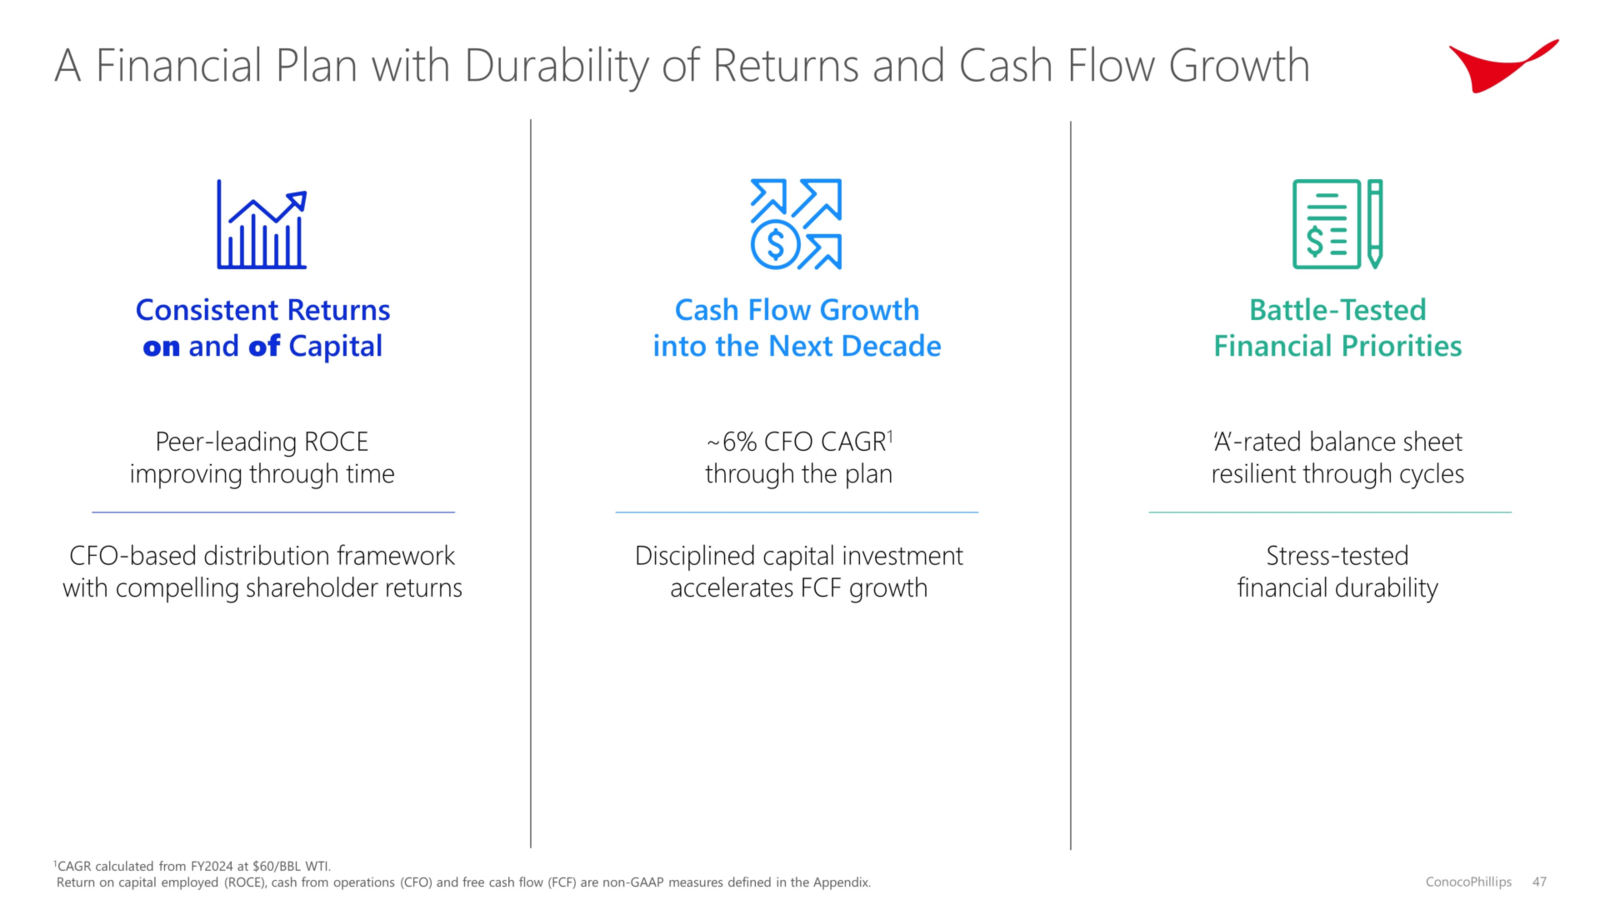

**Key Indicators of Stability: **

1. **Consistent Returns on and of Capital:** The company has a strong track record of delivering returns on capital employed (ROCE) and has set a goal to maintain peer-leading ROCE performance. The five-year average ROCE for ConocoPhillips is 14%, which is higher than many of its peers.

2. **Cash Flow Growth:** ConocoPhillips projects a compound annual growth rate (CAGR) of ~6% for cash from operations (CFO) and ~11% for free cash flow (FCF) from 2024 to 2032 at a $60/BBL WTI price. This indicates a robust growth trajectory for cash flow.

3. **Strong Balance Sheet:** The company aims to reduce its debt by $5 billion by 2026, which will result in an annual interest reduction of approximately $250 million. The net debt to CFO ratio is projected to be 0.3x on average from 2024 to 2028, indicating a strong balance sheet.

4. **Distribution Commitment:** ConocoPhillips has committed to returning 30% of CFO to shareholders through dividends and share buybacks, which demonstrates a focus on shareholder returns.

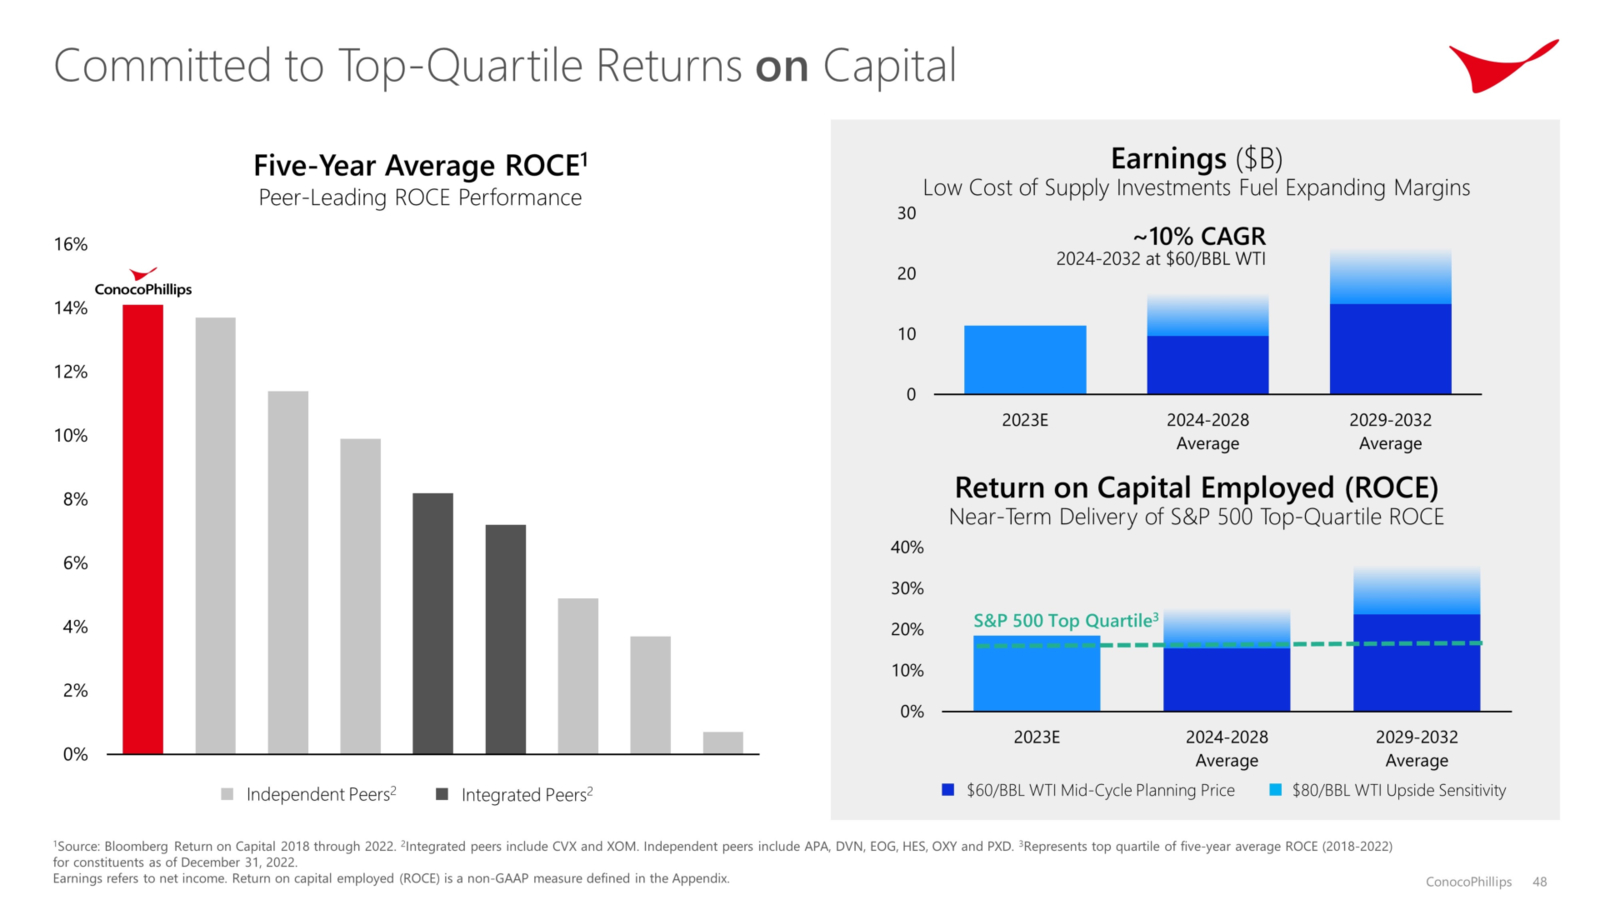

**Potential Risk Factors: **

1. **Commodity Price Volatility:** The financial projections are based on certain price assumptions for oil and gas. Any significant deviation from these price assumptions could impact the company's cash flow and profitability. For example, a prolonged decline in oil prices could reduce cash from operations and free cash flow.

2. **Regulatory and Environmental Risks:** Changes in environmental regulations or the imposition of new carbon taxes could increase operating costs and impact profitability. The company's commitment to reducing greenhouse gas emissions and achieving net-zero emissions by 2050 also involves significant investments and operational changes.

3. **Operational Risks:** Potential failures or delays in achieving expected production levels from existing and future developments could impact financial performance. This includes risks related to drilling, technical difficulties, and unexpected cost increases.

4. **Geopolitical Risks:** Global and regional changes, such as military conflicts, trade restrictions, and political instability, could affect the demand, supply, and prices of oil and gas. The ongoing conflict between Russia and Ukraine is an example of a geopolitical risk that could impact the company's operations and financial performance.

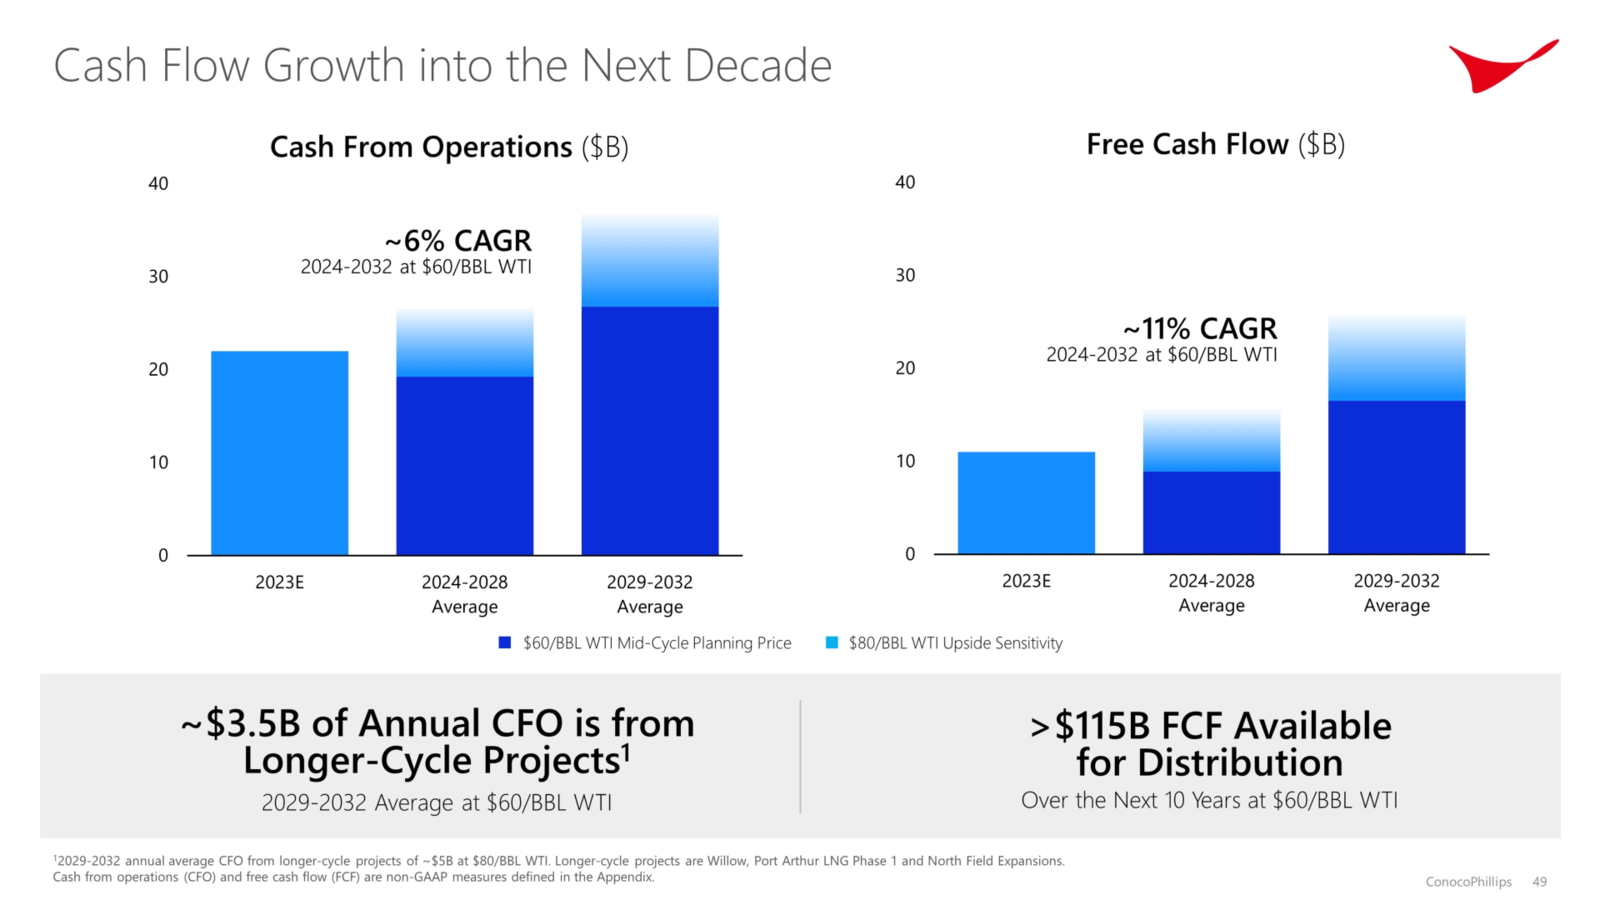

In conclusion, while ConocoPhillips' financial projections appear stable and are supported by a strong balance sheet, consistent returns, and robust cash flow growth, there are several potential risk factors that could impact these projections. Commodity price volatility, regulatory and environmental risks, operational challenges, and geopolitical uncertainties are key factors that need to be monitored.

In [ ]:
response.response.render()

In [ ]:
from app.routes.temp import md_json_objs

In [34]:
from pinecone import Pinecone, ServerlessSpec

pc = Pinecone()

In [35]:
index_name = "quickstart"

pc.create_index(
    name=index_name,
    dimension=2, # Replace with your model dimensions
    metric="cosine", # Replace with your model metric
    spec=ServerlessSpec(
        cloud="aws",
        region="us-east-1"
    ) 
)

In [36]:
pc.list_indexes()

[
    {
        "name": "quickstart",
        "dimension": 2,
        "metric": "cosine",
        "host": "quickstart-7mdjkcg.svc.aped-4627-b74a.pinecone.io",
        "spec": {
            "serverless": {
                "cloud": "aws",
                "region": "us-east-1"
            }
        },
        "status": {
            "ready": true,
            "state": "Ready"
        },
        "deletion_protection": "disabled"
    }
]

In [37]:
from fastapi import HTTPException
import uuid
import boto3
s3_client = boto3.client('s3')
embed_model = OpenAIEmbedding(model="text-embedding-3-large", api_key=os.getenv("OPENAI_API_KEY"))
llm = OpenAI(model="gpt-4o", system_prompt="You are a report generation assistant...", logprobs=None)
Settings.embed_model = embed_model
Settings.llm = llm

def download_pdf_from_s3(pdf_name: str) -> str:
    temp_dir = "/tmp/"
    # Set a clear, fixed path with UUID for uniqueness
    pdf_path = os.path.join(temp_dir, f"{uuid.uuid4()}_{os.path.basename(pdf_name)}")
    try:
        # Ensure the file downloads to the specified path without suffix
        s3_client.download_file("cfapublications", pdf_name, pdf_path)
    except Exception as e:
        raise HTTPException(status_code=500, detail=f"Error downloading PDF from S3: {str(e)}")
    return pdf_path


In [38]:
pdf_name = "assignment3/pdfs/The Economics of Private Equity_ A Critical Review.pdf"

In [40]:
pdf_path = download_pdf_from_s3(pdf_name)
print(pdf_path)

/tmp/6636d92f-27a6-4e61-acbb-72756f6e3125_The Economics of Private Equity_ A Critical Review.pdf


[Document(id_='b568bf8f-2d81-4270-9beb-1a3e6fc965b2', embedding=None, metadata={'page_label': 'C1', 'file_name': '6636d92f-27a6-4e61-acbb-72756f6e3125_The Economics of Private Equity_ A Critical Review.pdf'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='THE ECONOMICS OF  \nPRIVATE EQUIT Y\nA CRITICAL REVIEWCFA INSTITUTE RESEARCH FOUNDATION / LITERATURE REVIEW\nALEXANDER LJUNGQVIST\n', mimetype='text/plain', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), Document(id_='705380ee-f67a-4ddf-8c09-698c30dc6547', embedding=None, metadata={'page_label': 'i', 'file_name': '6636d92f-27a6-4e61-acbb-72756f6e3125_The Economics of Private Equity_ A Critical Review.pdf'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='THE ECONOMICS OF \nPRIVATE EQUITY\nA CRITICAL REVIEW\nALEXANDER LJUNGQVIST\nStockholm School of Economic

'THE ECONOMICS OF PRIVATE EQUIT YA CRITICAL REVIEWCFA INSTITUTE RESEARCH FOUNDATION / LITERATURE REVIEWALEXANDER LJUNGQVIST'